In [2]:
import pandas as pd
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.models import load_model
import os

import tensorflow as tf
config = tf.compat.v1.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1660, pci bus id: 0000:1f:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [3]:
num_classes = 7
img_rows,img_cols = 48,48
batch_size = 32

train_data_dir = 'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/FER2013/Images/Training'
validation_data_dir = 'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/FER2013/Images/PublicTest'
validation_data_dir = 'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/FER2013/Images/PublicTest'

# train_data_dir = r'C:\Users\New User\Desktop\Fourth Year\Usability_Testing_FYP\Datasets\JAFFE\Training'
# validation_data_dir = r'C:\Users\New User\Desktop\Fourth Year\Usability_Testing_FYP\Datasets\JAFFE\Validation'

# Generates new images from the existing sample to increase the number of images
# This increases the accuracy. The generated images are the original that have been
# rescaled, shifted, rotated, flipped etc.
# Can generate 7 images from the original one
train_datagen = ImageDataGenerator(
					rescale=1./255,
					rotation_range=30,
					shear_range=0.3,
					zoom_range=0.3,
					width_shift_range=0.4,
					height_shift_range=0.4,
					horizontal_flip=True,
					fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
					train_data_dir,
					color_mode='grayscale',
					target_size=(img_rows,img_cols),
					batch_size=batch_size,
					class_mode='categorical',
					shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
							validation_data_dir,
							color_mode='grayscale',
							target_size=(img_rows,img_cols),
							batch_size=batch_size,
							class_mode='categorical',
							shuffle=True)


Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [4]:
model = Sequential()

# Block-1

model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-2 

model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-3

model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-4 

model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-5

model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block-6

model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block-7

model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

print(model.summary())

from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('Emotion_little_vgg2.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop,checkpoint,reduce_lr]

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

nb_train_samples = 24176
nb_validation_samples = 3006
epochs=25

history=model.fit_generator(
                train_generator,
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=epochs,
                callbacks=callbacks,
                validation_data=validation_generator,
                validation_steps=nb_validation_samples//batch_size)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0

In [12]:
model = load_model(r'C:\Users\New User\Desktop\Fourth Year\Usability_Testing_FYP\Src\Emotion_little_vgg2.h5')

# predictions = model.predict(x=validation_generator, verbose=0)

predictions = model.predict_generator(validation_generator, verbose=1,steps=3589/32)

print(predictions)

113/112 [==============================] - 1s 12ms/step
[[2.62510657e-01 1.46953166e-02 1.34669483e-01 ... 3.41881841e-01
  1.81971252e-01 5.65962605e-02]
 [2.88357940e-02 2.75845872e-03 1.47870202e-02 ... 1.21052198e-01
  6.85013086e-02 4.23924811e-03]
 [2.79388786e-03 3.66885390e-04 2.97586550e-03 ... 1.08896876e-02
  4.24369285e-03 1.82655570e-03]
 ...
 [5.91031536e-02 6.62170863e-03 4.30627577e-02 ... 2.05236688e-01
  3.28343421e-01 2.43339967e-03]
 [1.22801915e-01 8.99672415e-03 2.92701900e-01 ... 2.13888079e-01
  1.82399049e-01 1.68780431e-01]
 [1.44918248e-01 8.97815265e-03 1.25339419e-01 ... 3.35846573e-01
  3.68569344e-01 9.13043600e-03]]


In [13]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
[0, 1, 2, 3, 4, 5, 6]
(3589,)
Confusion matrix, without normalization
[[ 67   0  16 112 143  66  63]
 [  6   0   3   9  13  13  12]
 [ 64   0  21 108 155  67  81]
 [110   0  40 177 275 154 139]
 [ 80   0  32 119 181 103  92]
 [ 96   0  32 146 184 105  90]
 [ 46   0  19  98 122  72  58]]


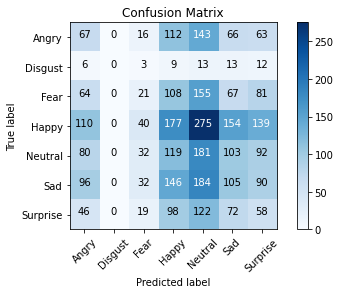

In [14]:
emotionsList = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
print(validation_generator.class_indices)
listClasses = []
for i in validation_generator.classes:
    if i not in listClasses:
        listClasses.append(i)
print(listClasses)
print(validation_generator.classes.shape)
        
cm = confusion_matrix(y_true=validation_generator.classes, y_pred=np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm=cm, classes=emotionsList, title='Confusion Matrix')

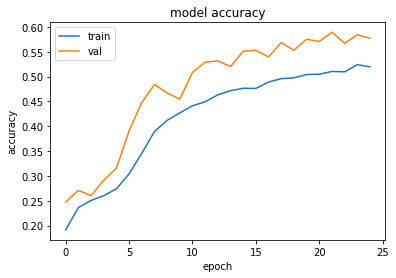

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

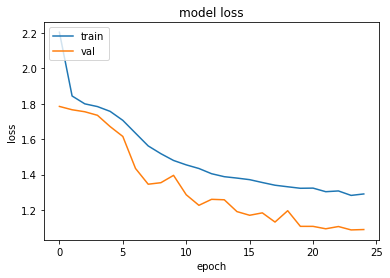

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()